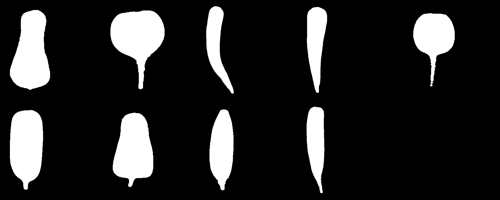

In [1]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/My Drive/RadishLab"
# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABROOT)
    COLABORATORY = True
except ImportError:
    COLABORATORY = False
    sys.path.append('./rdlib')
    
import rdlib.rdlib41 as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

SilF = labhome+'/RDSamples/silhoetteM' # シルエット画像のフォルダ
SrcF = labhome+'/RDSamples/croppedM' # 原画像のフォルダ

SilFnames = rd.collectimagepaths(SilF) # シルエット画像のファイル名リスト
imgs = rd.collectimages(SilF)       # シルエット画像のリスト
simgs = rd.collectimages(SrcF)
rd.makethumbnail(SilF)

# シルエットの左右分離

ダイコンのシルエットを先端と葉の付け根部分を基準に左右に分割したい。

左右分割を考えるのは、

1. フーリエ記述子のような全周を対象とした記述方法以外の表現の応用可能性に道を開く。
2. ダイコンは（理想的には）軸対称図形であるので、左右どちらかだけでその形状とみなせる。
3. ダイコンの形状を「軸の形状」と「軸に沿った幅の変化の様子」ととらえることができる。
4. 漠然と「幅」という概念が用いられるが、幅という概念は軸という概念があってはじめて成り立つ。
5. 左右の輪郭が与えられれば、それをもとに軸を推定できる可能性がある。

など理由。

我々の思い浮かべるダイコンの形状は軸対称であり、実際の個体には曲がりがあるとしても、なんとなく、”葉の付け根”の中央から”先端”に向かう軸をイメージすることができる。

典型的な線対称の砲弾型のシルエットを思い浮かべると、自動的に軸を見つけて左右分割することは容易なように
思われるが、実際にはそう容易ではない。


## バウンディングボックスでは？
例えばバウンディングボックスの上下の辺と輪郭の接点を左右分割の基準にできないか試してみよう。

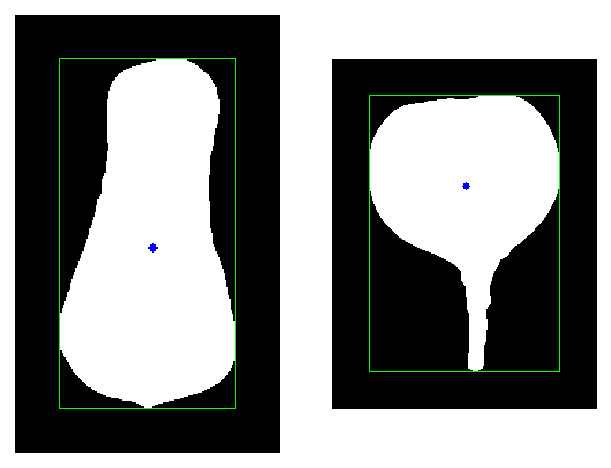

In [2]:
# 重心位置とバウンディングボックス
img0 = imgs[0].copy()
img1 = imgs[1].copy()
x0,y0,con0 = rd.getCoG(img0)
x1,y1,con1 = rd.getCoG(img1)
outimg0 = cv2.cvtColor(img0,cv2.COLOR_GRAY2BGR)
outimg1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
cv2.circle(outimg0,(int(x0),int(y0)),3,(255,0,0),-1)
cv2.rectangle(outimg0,con0,(0,255,0))
cv2.circle(outimg1,(int(x1),int(y1)),3,(255,0,0),-1)
cv2.rectangle(outimg1,con1,(0,255,0),1)
plt.figure(figsize=(5,5),dpi=150)
rd.plotimg(outimg0,layout="121")
rd.plotimg(outimg1,layout="122")

図でわかるように、下端はいけそうであるが、上端はうまくいかなそうである。

# 中心軸の起点らしさの尺度

仮に図形が線対称であるとする。輪郭線上でかつ対称軸上に点$P$をとる。点$P$から輪郭線に沿って反時計回りにN画素分移動した位置にある画素$P_-$と時計回りに同じ画素分移動した位置にある点$P_＋$を通る直線と、$P_-P_+$の中点$P_m$と$P$を結ぶ直線$PP_m$とは直交する。


$$E = -\sum_{n=1}^{N}\left| \frac{PP_m\cdot P_-P_+}{N|PP_m||P_-P_m|} \right|$$ 

とおくと、図形が線対称で、点$P$が軸上にあるのであれば、$E$の値は０であり、そうでなければ負の値となる。

図形が線対称でなければ、点Pをどこに取ったとしても、評価関数$E$は０となることはないが、

In [3]:
# 対称性評価基準
def evalSymmetry(img):
    con = rd.getContour(img).tolist() # 輪郭点列のリスト
    gx,gy,(x0,y0,w,h,a) = rd.getCoG(img) # 重心とバウンディングボックス
    N = len(con) # 輪郭点列の数)
    HL = N//3
    
    def calcval(i):
        val = 100
        vc = 0
        for n in range(5,HL):
            p0,p1,p2 = con[i],con[(i-n)%N],con[(i+n)%N]
            v1 = (p2[0]-p1[0],p2[1]-p1[1]) # p1p2 ベクトル
            p3 = ((p1[0]+p2[0])/2,(p1[1]+p2[1])/2) # p3 = p1とp2の中点
            v2 = (p3[0]-p0[0],p3[1]-p0[1]) # p0p3 ベクトル
            nv1 = np.linalg.norm(v1) # p1p2 の長さ
            nv2 = np.linalg.norm(v2) # p0p3 の長さ
            if nv2 > 0: # 中点p3とp0が一致するときを避けるための条件
                vc += 1
                val += np.abs(np.dot(v1,v2)/nv1/nv2)
        return -1 if vc==0  else val/vc

    # 上部の端点の探索
    symtops = []
    for i in range(N):
        if con[i][1] - y0 >= h/8: # バウンディングボックス上端からの距離
            val = -1
        else:
            val = calcval(i)
        symtops.append(val)
    m = np.max(symtops) - 100 # 探索対象のうちの最大評価値
    for i in range(N):
        if symtops[i] < 0: 
            symtops[i] = m
        else:
            symtops[i] -= 100
    topTip = np.argmin(symtops)
    
    # 下部の端点の探索
    symbottoms = []
    for i in range(N):
        if con[i][1] - y0 < 7*h/8: # バウンディングボックス上端からの距離
            val = -1
        else:
            val = calcval(i)
        symbottoms.append(val)
    m = np.max(symbottoms) - 100 # 探索対象のうちの最大評価値
    for i in range(N):
        if symbottoms[i] < 0: 
            symbottoms[i] = m
        else:
            symbottoms[i] -= 100
    bottomTip = np.argmin(symbottoms)
    
    return con,topTip,bottomTip,symtops,symbottoms

17 330


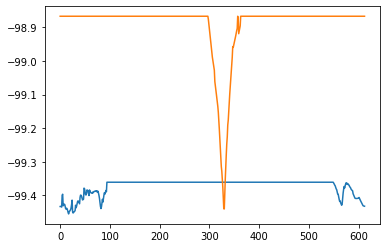

In [4]:
img0 = imgs[1].copy()
con,topTip0,bottomTip0,symtops,symbottoms = evalSymmetry(img0)
plt.plot(symtops)
plt.plot(symbottoms)
print(topTip0,bottomTip0)

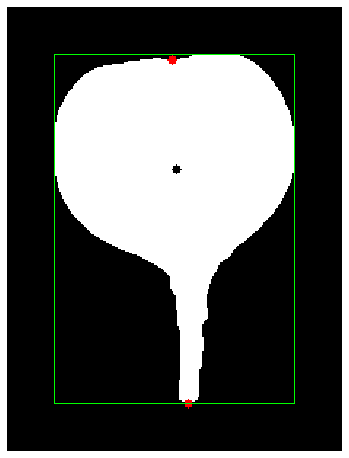

In [5]:
gx,gy,rect = rd.getCoG(img0) # 重心
outimg = cv2.cvtColor(img0,cv2.COLOR_GRAY2BGR)
cv2.circle(outimg,(int(con[topTip0][0]),int(con[topTip0][1])),3,(0,0,255),-1)
cv2.circle(outimg,(int(con[bottomTip0][0]),int(con[bottomTip0][1])),3,(0,0,255),-1)
cv2.circle(outimg,(int(gx),int(gy)),3,(0,0,0),-1)
cv2.rectangle(outimg,rect,(0,255,0),1)
plt.figure(figsize=(6,10))
rd.plotimg(outimg)

In [6]:
def plottips(img,layout='111'):
    img = img.copy()
    con,topTip,bottomTip,symtops,symbottoms = evalSymmetry(img)
    # plt.plot(symtops)
    # plt.plot(symbottoms)
    gx,gy,rect = rd.getCoG(img) # 重心
    outimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    cv2.circle(outimg,(int(con[topTip][0]),int(con[topTip][1])),5,(0,0,255),-1)
    cv2.circle(outimg,(int(con[bottomTip][0]),int(con[bottomTip][1])),5,(0,0,255),-1)
    cv2.circle(outimg,(int(gx),int(gy)),5,(0,0,0),-1)
    cv2.rectangle(outimg,rect,(0,255,0),1)
    rd.plotimg(outimg,layout=layout)

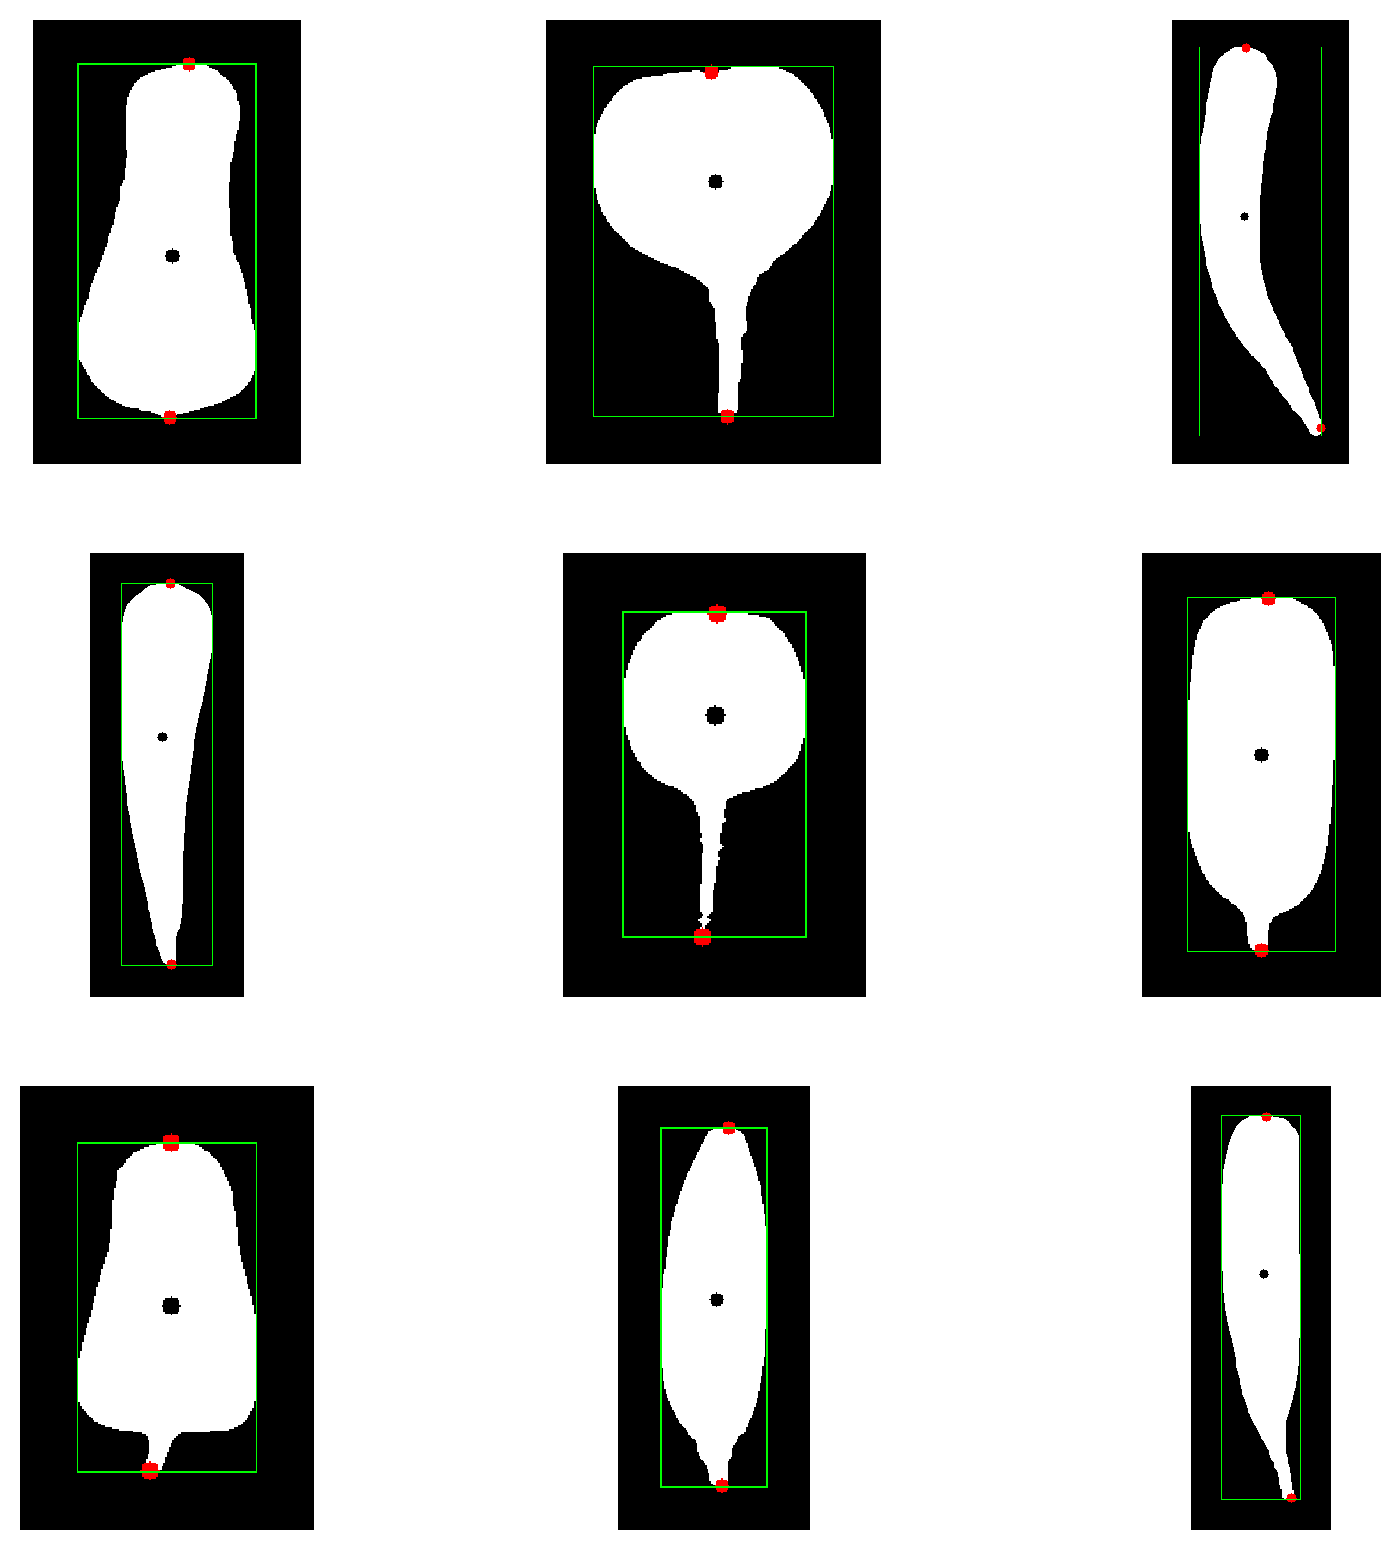

In [7]:
plt.figure(figsize=(10,10),dpi=200)
plottips(imgs[0],layout='331')
plottips(imgs[1],layout='332')
plottips(imgs[2],layout='333')
plottips(imgs[3],layout='334')
plottips(imgs[4],layout='335')
plottips(imgs[5],layout='336')
plottips(imgs[6],layout='337')
plottips(imgs[7],layout='338')
plottips(imgs[8],layout='339')

# 考察

われわれの思い浮かべる理想的なダイコンは軸対象であり、幅や長さといった概念は対称軸を仮定して初めて成立する。左右対称な図形であれば形状は形状記述はシルエットの半分を対象とすればよい。

種や個体の特徴として、”軸の湾曲”を挙げることがあるが、それも、曲がりのない左右対称を基準とした概念である。

図形が正確に線対称なのであればその対称軸は必ず重心を通るはずなので、そのような直線を候補とし、図形がその直線に対して線対称となるかどうかを判定することで、対称軸をサーチすればよい。

しかし、残念ながら現実の個体のシルエットは一般に左右対称図形ではない。対称形に変形を加えた結果が観測されているのだとしても、変形後の図形を入力として、元の左右対称図形とそれに加えられた変形操作を分離することは容易ではない。